Centro de Estudos e Sistemas Avançados do Recife

Pós-graduação em Engenharia e Análise de Dados

Disciplina de RNA e Deep Learning

Professor: Silvan Ferreira da Silva Junior 
 
Grupo:
* Anísio Pereira Batista Filho (apbf@cesar.school)
* Carlos Cezar Lopes de Mendonça (cclm@cesar.school)
* Rodolpho Victor França Valsconcelos (rvfv@cesar.school)

# Introdução às Redes Convolucionais com PyTorch

Neste notebook, vamos explorar Redes Neurais usando a biblioteca PyTorch. Vamos começar com uma Rede Neural Totalmente Conectada (Fully Connected Network) para classificar dígitos do dataset MNIST. Em seguida, substituiremos a rede por uma Rede Neural Convolucional (CNN) e compararemos os resultados.

## Objetivos
- Carregar e preprocessar o dataset MNIST.
- Implementar uma Rede Neural Totalmente Conectada.
- Treinar e avaliar a rede.
- Substituir a rede por uma CNN e comparar os resultados.

In [2]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
# from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## Carregando e Preprocessando o Dataset MNIST

O dataset MNIST contém 60.000 imagens de treinamento e 10.000 imagens de teste de dígitos manuscritos, de 0 a 9.

In [6]:
# Download do dataset MNIST into data dir
# ! wget https://pjreddie.com/media/files/mnist_train.csv -P data

# Fazendo o download do dataset MNIST com curl
! curl -o data/mnist_train.csv https://pjreddie.com/media/files/mnist_train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  104M    0 70638    0     0  42939      0  0:42:31  0:00:01  0:42:30 43098
  0  104M    0  516k    0     0   192k      0  0:09:16  0:00:02  0:09:14  192k
  1  104M    1 1092k    0     0   299k      0  0:05:57  0:00:03  0:05:54  299k
  1  104M    1 1683k    0     0   360k      0  0:04:56  0:00:04  0:04:52  361k
  2  104M    2 2402k    0     0   425k      0  0:04:11  0:00:05  0:04:06  520k
  2  104M    2 3202k    0     0   480k      0  0:03:42  0:00:06  0:03:36  624k
  3  104M    3 4001k    0     0   523k      0  0:03:24  0:00:07  0:03:17  702k
  4  104M    4 4800k    0     0   553k      0  0:03:13  0:00:08  0:03:05  738k
  5  104M    5 5599k    0     0   579k      0  0:03

In [7]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [9]:
# Criando índices aleatórios para os subsets de treino e teste
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

train_indices = indices[:10000]  # Primeiros 10.000 índices para o trainset
test_indices = indices[10000:11000]  # Próximos 1.000 índices para o testset

trainset = Subset(mnist_dataset, train_indices)
testset = Subset(mnist_dataset, test_indices)

In [10]:
# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

## Visualizando Algumas Imagens do Dataset

Vamos visualizar algumas imagens do dataset de treino para entender melhor os dados com os quais estamos trabalhando.

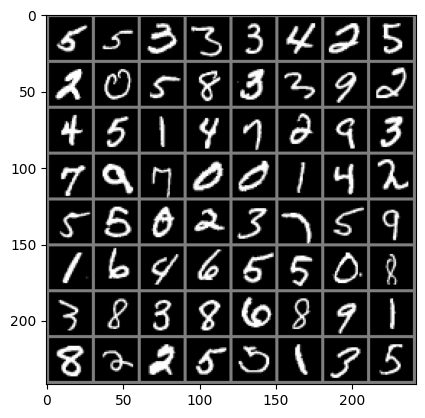

Labels:  5 5 3 3 3 4 2 5


In [11]:
# Função para mostrar uma imagem
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Obter algumas imagens de treinamento
images, labels = next(iter(trainloader))

# Mostrar imagens
imshow(torchvision.utils.make_grid(images))
# Mostrar labels
print('Labels: ', ' '.join('%d' % labels[j] for j in range(8)))

In [12]:
def train_model(model, trainloader, criterion, optimizer, num_epochs=5):
    train_losses = []
    accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            # Obter os inputs; data é uma lista de [inputs, labels]
            inputs, labels = data

            # Zerar os gradientes dos parâmetros otimizados
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Estatísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 50 == 49:
                train_losses.append(running_loss / 100)
                running_loss = 0.0

        epoch_acc = 100 * correct / total
        accuracies.append(epoch_acc)
        print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.3f}, Accuracy: {epoch_acc:.2f}%')
    print('Treinamento concluído')
    return train_losses, accuracies


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Definindo a Rede Neural Totalmente Conectada

Vamos definir uma arquitetura simples de Rede Neural Totalmente Conectada (FCN).

In [13]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

fcn_model = FCN()

In [14]:
fcn_params = count_parameters(fcn_model)
print(f"Total de parâmetros na FCN: {fcn_params}")

Total de parâmetros na FCN: 109386


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcn_model.parameters(), lr=0.01, momentum=0.9)

In [16]:
# Treinando a FCN
fcn_losses, fcn_accuracies = train_model(fcn_model, trainloader, criterion, optimizer)

100%|██████████| 157/157 [00:11<00:00, 14.14it/s]


Epoch 1, Loss: 0.257, Accuracy: 68.20%


100%|██████████| 157/157 [00:11<00:00, 14.23it/s]


Epoch 2, Loss: 0.178, Accuracy: 87.71%


100%|██████████| 157/157 [00:11<00:00, 13.67it/s]


Epoch 3, Loss: 0.149, Accuracy: 89.84%


100%|██████████| 157/157 [00:10<00:00, 14.51it/s]


Epoch 4, Loss: 0.118, Accuracy: 91.73%


100%|██████████| 157/157 [00:10<00:00, 14.86it/s]

Epoch 5, Loss: 0.110, Accuracy: 93.01%
Treinamento concluído


In [17]:
# Testando a FCN
test_model(fcn_model, testloader)

Acurácia da rede na base de teste: 92.10%


## Substituindo a Rede Neural por uma CNN

Agora, vamos substituir a Rede Neural Totalmente Conectada por uma Rede Neural Convolucional (CNN) e comparar os resultados.

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

cnn_model = CNN()

In [19]:
cnn_params = count_parameters(cnn_model)
print(f"Total de parâmetros na CNN: {cnn_params}")

Total de parâmetros na CNN: 14970


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

In [21]:
# Treinando a CNN
cnn_losses, cnn_accuracies = train_model(cnn_model, trainloader, criterion, optimizer)

100%|██████████| 157/157 [00:16<00:00,  9.62it/s]


Epoch 1, Loss: 0.191, Accuracy: 63.45%


100%|██████████| 157/157 [00:16<00:00,  9.75it/s]


Epoch 2, Loss: 0.088, Accuracy: 93.68%


100%|██████████| 157/157 [00:15<00:00, 10.42it/s]


Epoch 3, Loss: 0.063, Accuracy: 95.34%


100%|██████████| 157/157 [00:13<00:00, 11.73it/s]


Epoch 4, Loss: 0.046, Accuracy: 96.61%


100%|██████████| 157/157 [00:14<00:00, 10.76it/s]

Epoch 5, Loss: 0.044, Accuracy: 97.40%
Treinamento concluído


In [22]:
# Testando a CNN
test_model(cnn_model, testloader)

Acurácia da rede na base de teste: 97.30%


## Comparando as duas redes neurais

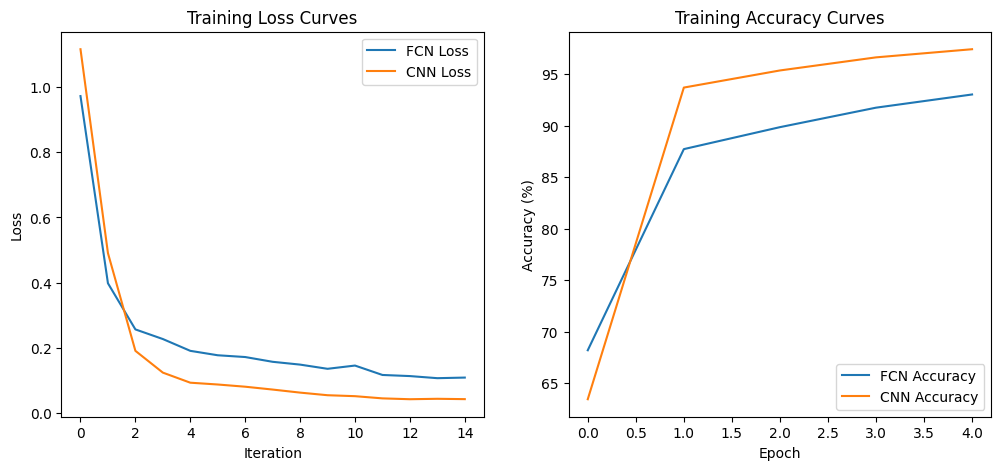

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fcn_losses, label='FCN Loss')
plt.plot(cnn_losses, label='CNN Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fcn_accuracies, label='FCN Accuracy')
plt.plot(cnn_accuracies, label='CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curves')
plt.legend()

plt.show()

## Exercícios

### Exercício 1
Altere a estrutura da rede e diminua o número de parâmetros na rede FC. O que se observa no resultado do treinamento?

In [26]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Denifindo a FCN
fcn_model = FCN()

# Contando os parâmetros da FCN
fcn_params = count_parameters(fcn_model)
print(f"Total de parâmetros na FCN: {fcn_params}")

# Definindo criterion e optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcn_model.parameters(), lr=0.01, momentum=0.9)

# Treinando a FCN
fcn_losses, fcn_accuracies = train_model(fcn_model, trainloader, criterion, optimizer)

# Testando a FCN
test_model(fcn_model, testloader)

Total de parâmetros na FCN: 52650


  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:11<00:00, 13.80it/s]


Epoch 1, Loss: 0.295, Accuracy: 64.62%


100%|██████████| 157/157 [00:11<00:00, 13.15it/s]


Epoch 2, Loss: 0.185, Accuracy: 86.82%


100%|██████████| 157/157 [00:10<00:00, 14.85it/s]


Epoch 3, Loss: 0.158, Accuracy: 89.17%


100%|██████████| 157/157 [00:10<00:00, 15.35it/s]


Epoch 4, Loss: 0.146, Accuracy: 90.89%


100%|██████████| 157/157 [00:11<00:00, 14.23it/s]


Epoch 5, Loss: 0.113, Accuracy: 92.36%
Treinamento concluído
Acurácia da rede na base de teste: 91.10%


Resposta: Em relação ao resultado anterior da FCN percebemos uma leve piora dos resultados de accuracy para treino, (de 93,01% para 92,36%) e para teste (de 92,10% para 91,10%).

### Exercício 2
Aumente o número de filtros convolucionais na CNN. O que se observa no resultado do treinamento em comparação ao anterior? Lembre-se de ajustar os valores das camadas seguintes.

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)  # Aumentando para 16 filtros
        self.conv2 = nn.Conv2d(16, 32, 5)  # Aumentando para 32 filtros
        self.fc1 = nn.Linear(32 * 4 * 4, 128)  # Ajustando o tamanho da camada totalmente conectada
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Denifindo o modelo
cnn_model = CNN()

# Contando os parâmetros da CNN
cnn_params = count_parameters(cnn_model)
print(f"Total de parâmetros na CNN: {cnn_params}")

# Definindo criterion e optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
cnn_losses, cnn_accuracies = train_model(cnn_model, trainloader, criterion, optimizer)

# Testando a CNN
test_model(cnn_model, testloader)

Total de parâmetros na CNN: 80202


100%|██████████| 157/157 [00:21<00:00,  7.38it/s]


Epoch 1, Loss: 0.151, Accuracy: 70.93%


100%|██████████| 157/157 [00:22<00:00,  7.09it/s]


Epoch 2, Loss: 0.076, Accuracy: 94.59%


100%|██████████| 157/157 [00:20<00:00,  7.55it/s]


Epoch 3, Loss: 0.045, Accuracy: 96.44%


100%|██████████| 157/157 [00:20<00:00,  7.57it/s]


Epoch 4, Loss: 0.040, Accuracy: 97.46%


100%|██████████| 157/157 [00:20<00:00,  7.60it/s]


Epoch 5, Loss: 0.032, Accuracy: 98.15%
Treinamento concluído
Acurácia da rede na base de teste: 97.70%


Resposta: Em relação ao resultado anterior da CNN percebemos uma leve melhora dos resultados de accuracy para treino, (de 97,40% para 98,15%) e para teste (de 97,30% para 97,70%).